In [57]:
#importing libraries as well as my dataset.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv("data.csv")
shooting_stats = pd.read_csv('Player Shooting Stats.csv')
#shooting_stats.head()

In [58]:
#want to make a new dataset that finds the shots that are shot, matches them with the player shooting, and finds the expected split

#first, I am going to make some edits to the dataset that get rid of players on multiple teams
#those players have a combined row with takes all their data and combines it into one, and I am taking the combined row out
drop_con = (shooting_stats['Tm'] == 'TOT')
shooting_stats = shooting_stats[~drop_con]


data['Shooting Percent at Distance'] = pd.NA
data['Expected Points per Shot'] = pd.NA

#getting column indexes
distance_percent_value = data.columns.get_loc('Shooting Percent at Distance')
player_name_value = data.columns.get_loc('player_name')
distance_column_value = data.columns.get_loc('result_dist')
tm_column = data.columns.get_loc('off_team')
pts_value = data.columns.get_loc('result_pts')

#getting indexes for the shooting splits dataframe
short, short_mid, mid_mid, long_mid, three_point, corner_three = np.arange(9,15)

#creating a function to sort the shot distance into our given shot distance categories
def shot_convert(distance, points):
    if 0 <= distance < 3:
        val = 4
    elif 3 <= distance < 10:
        val = 5
    elif 10 <= distance < 16:
        val = 6
    elif (22 <= distance < 23.75) and (points == 3):
        val = 9
    elif 16 <= distance < 23.75:
        val = 7
    else:
        val = 8
    return val

#now making a function that uses the player's name, team, and shot distance to find their FG% from that area
def percentage_finder(val1, val2, val3, val4):
    selected_row = shooting_stats.loc[(shooting_stats['Player'] == val1) & (shooting_stats['Tm'] == val2)]
    # Check if selected_row is empty
    if not selected_row.empty:
        range_column = shot_convert(val3, val4) 
        # Check if range_column is within the valid range
        if 0 <= range_column < len(selected_row.columns):
            percentage = selected_row.iloc[0, range_column]
            return percentage
        else:
            print(f"Invalid range_column: {range_column}")
            return None
    else:
        print(f"No matching rows for {val1} and {val2}")
        return None  # or return a default value or handle accordingly

#for the made shots
for i in range(len(data)):
    if (data.iloc[i, pts_value] in [1, 2, 3]) and (data.iloc[i, 14] == 'OFF'):
        name = data.iloc[i, player_name_value]
        team = data.iloc[i, tm_column]
        distance = data.iloc[i, distance_column_value]
        points = data.iloc[i, pts_value]
        data.iloc[i,-2] = percentage_finder(name, team, distance, points)
        data.iloc[i,-1] = (data.iloc[i,-2] * data.iloc[i, pts_value])
    else:
        continue
#now we have a dataframe with a shooting percentage for each specific player at distance and the expected value of their shot

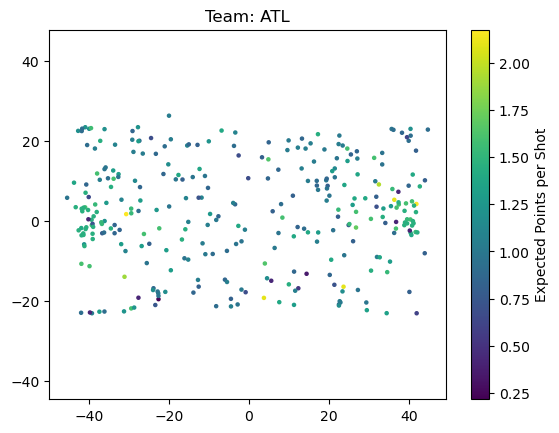

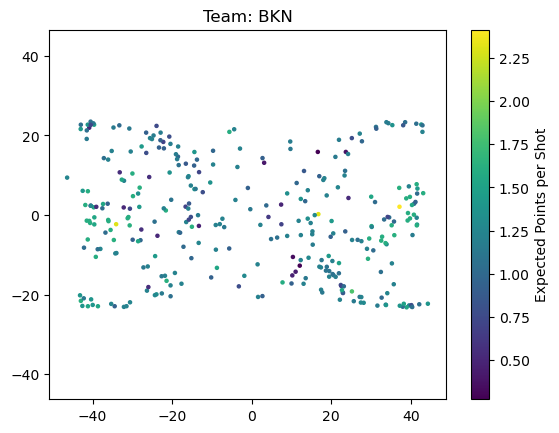

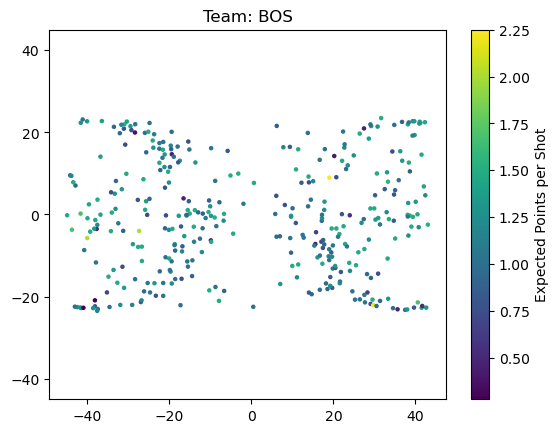

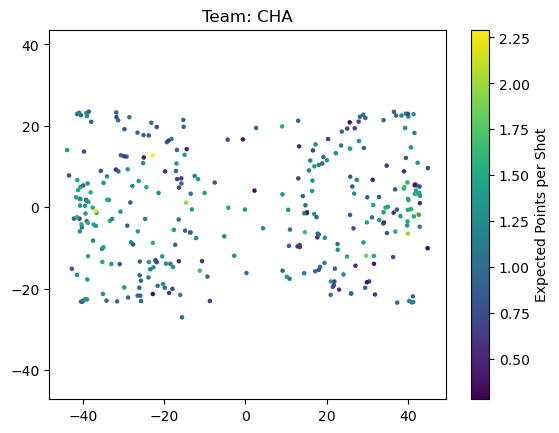

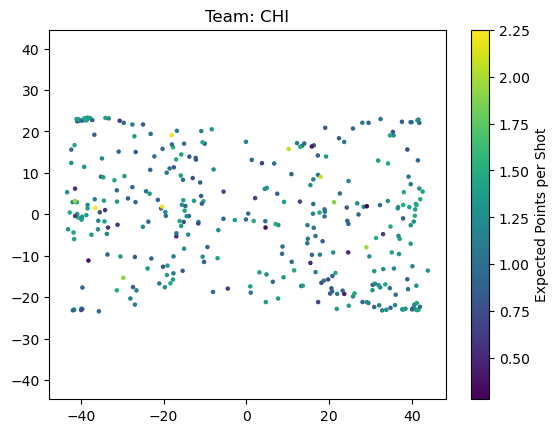

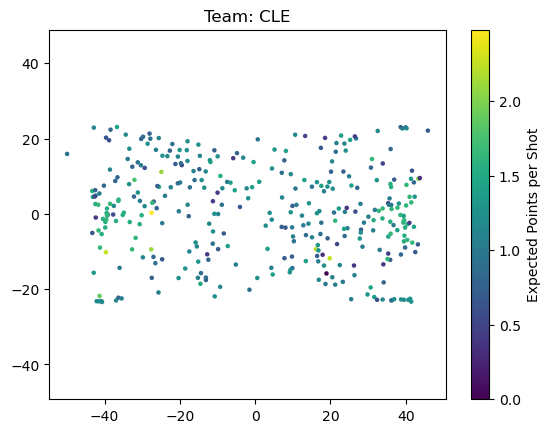

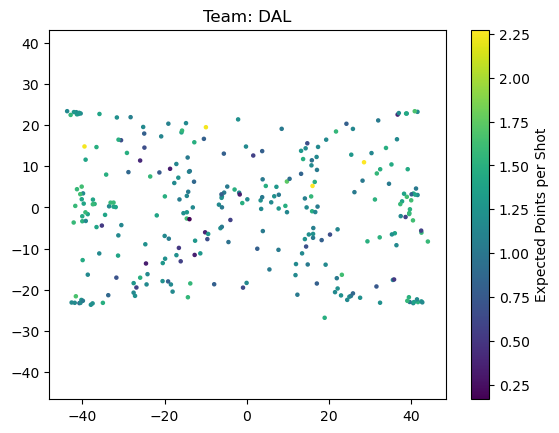

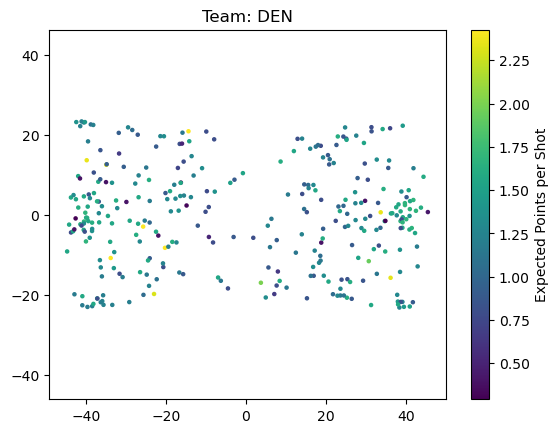

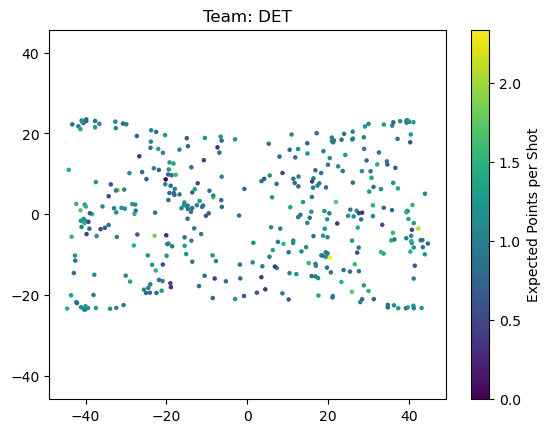

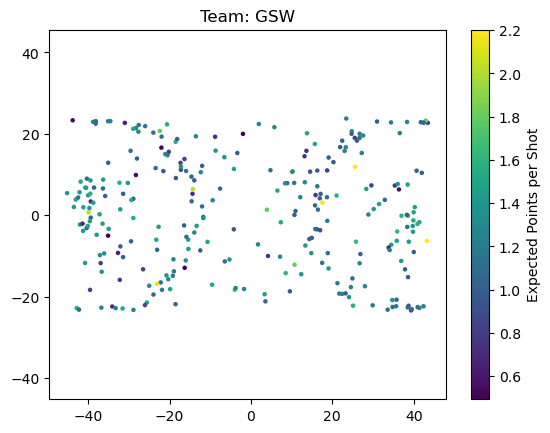

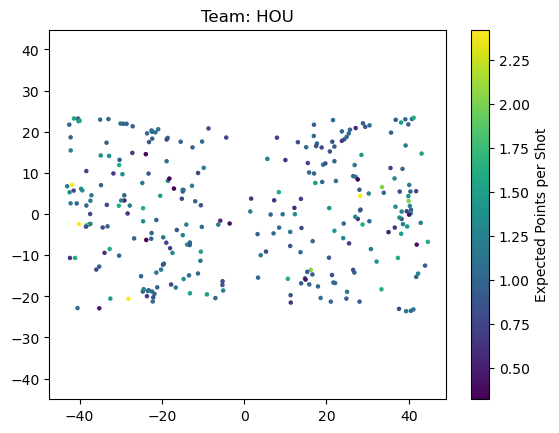

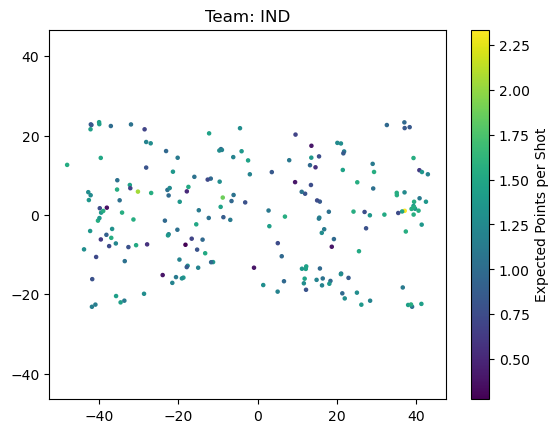

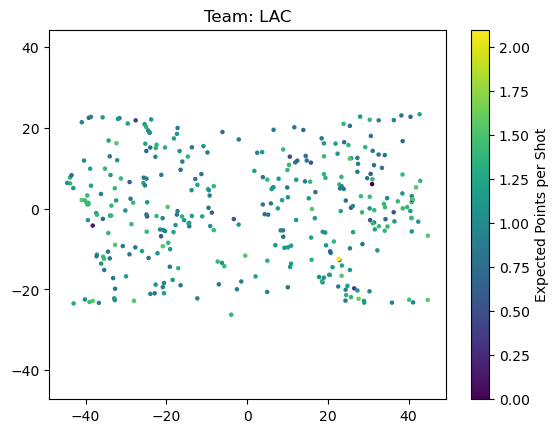

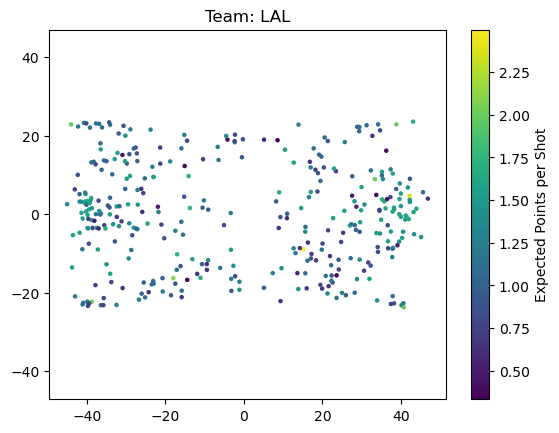

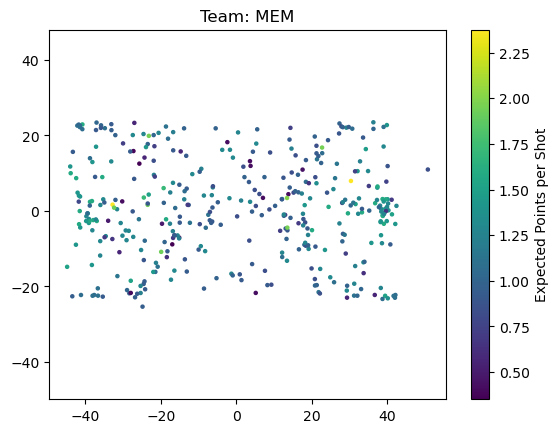

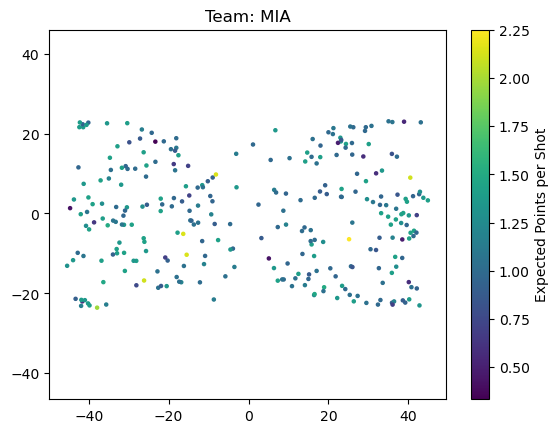

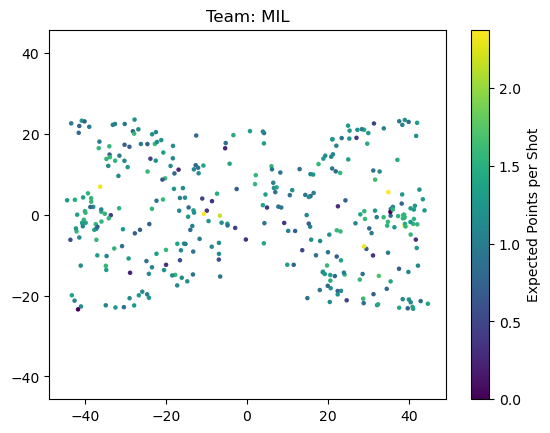

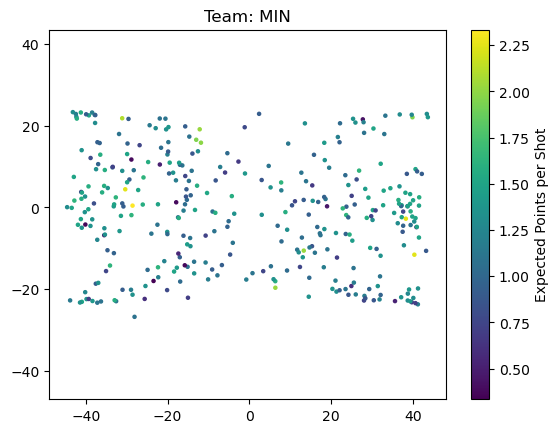

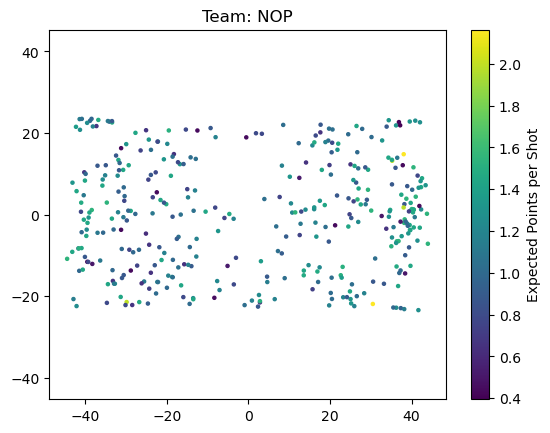

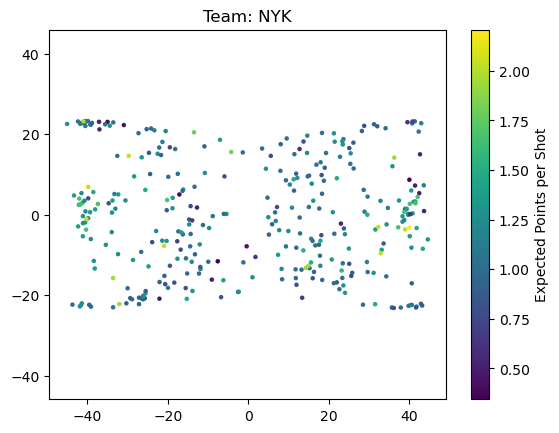

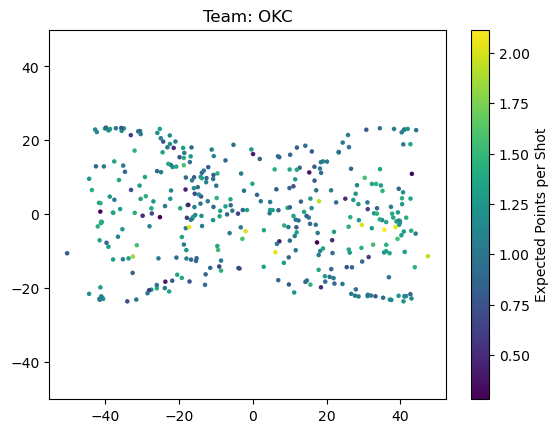

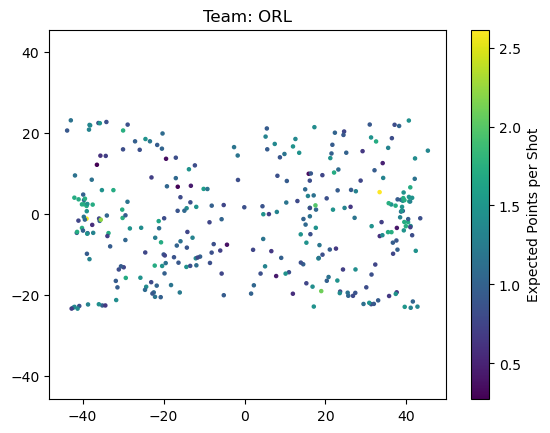

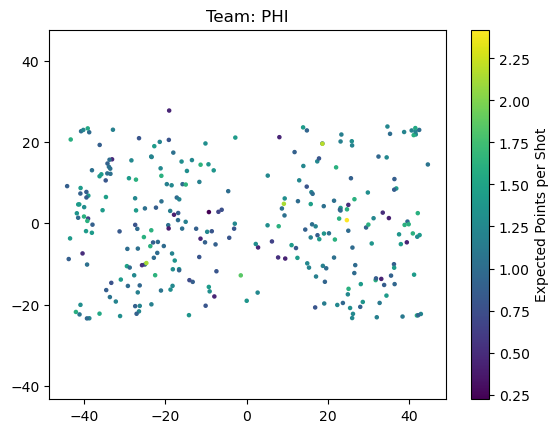

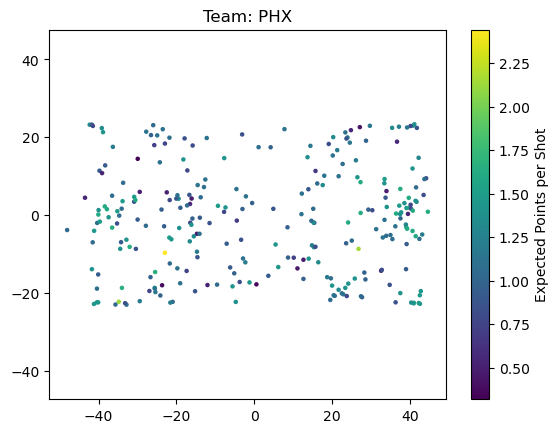

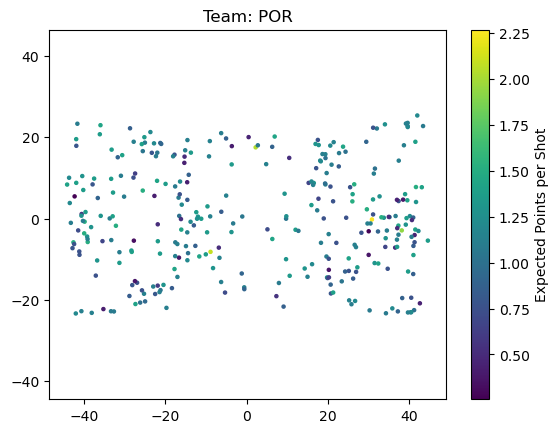

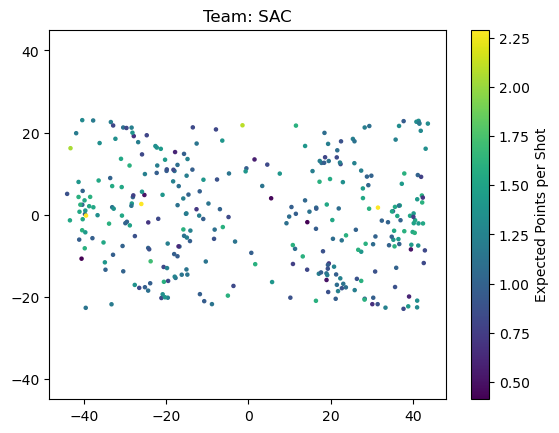

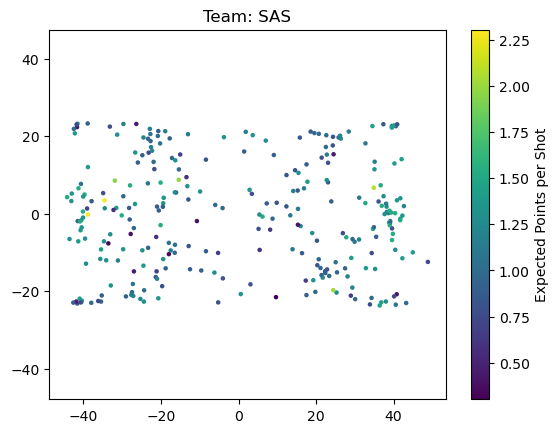

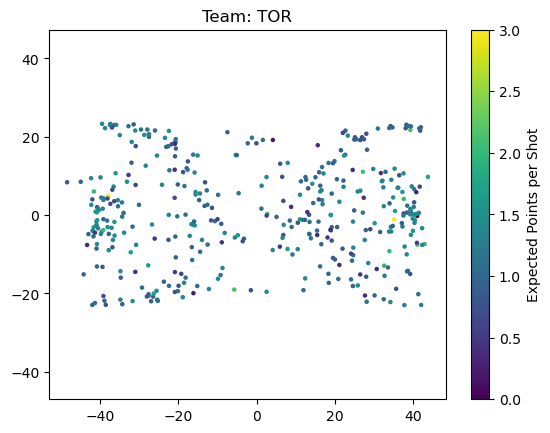

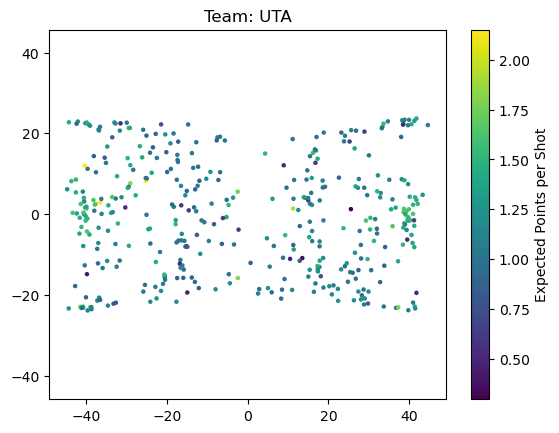

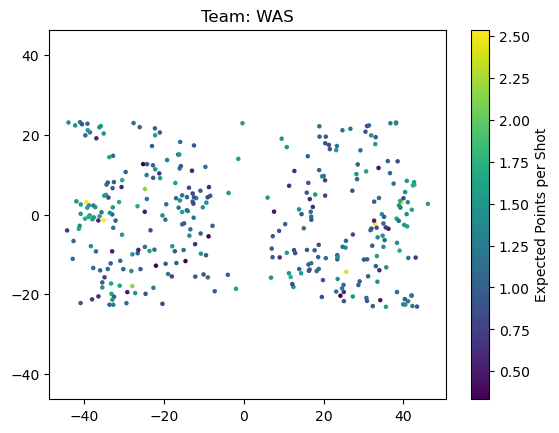

Empty DataFrame
Columns: []
Index: []

In [59]:
#making graphs for each team with locations of successful shots

# starting with making a dataframe with only made shots
column_check = ['Shooting Percent at Distance', 'Expected Points per Shot']
made_shots = data.dropna(subset = column_check)

#grouping by offensive team
team_shots = made_shots.groupby("off_team")

#importing matplotlib.pyplot and seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#making graphs on where these offensive shots come from
def graphs(group):
    plt.axis('equal')
    plt.scatter(group['player_x'], group['player_y'], c = group['Expected Points per Shot'], cmap = 'viridis', marker = 'o', s = 5)
    plt.colorbar(label = 'Expected Points per Shot')
    plt.title(f'Team: {group.name}')
    plt.show()

#apply the custom function to each group
team_shots.apply(graphs)

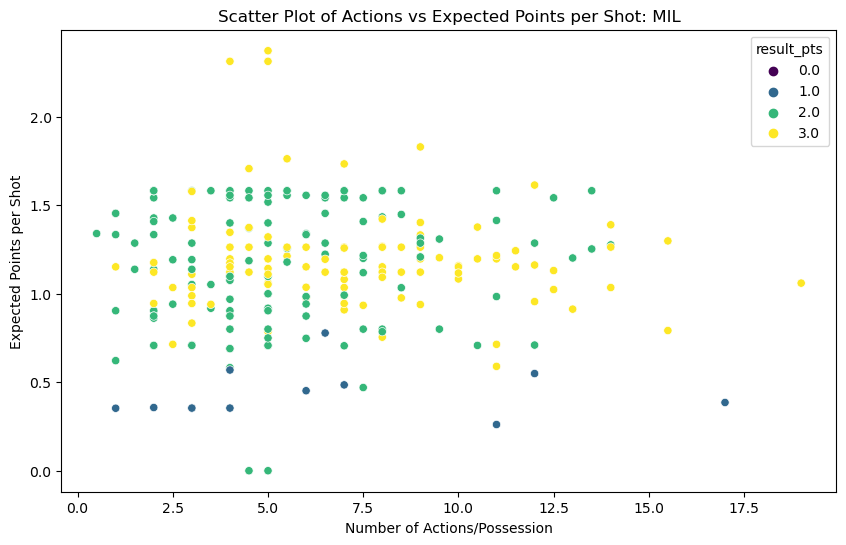

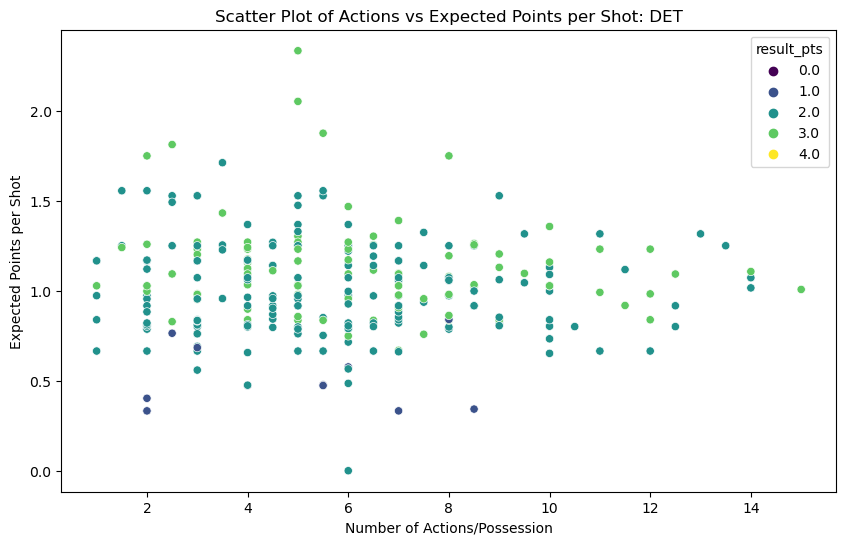

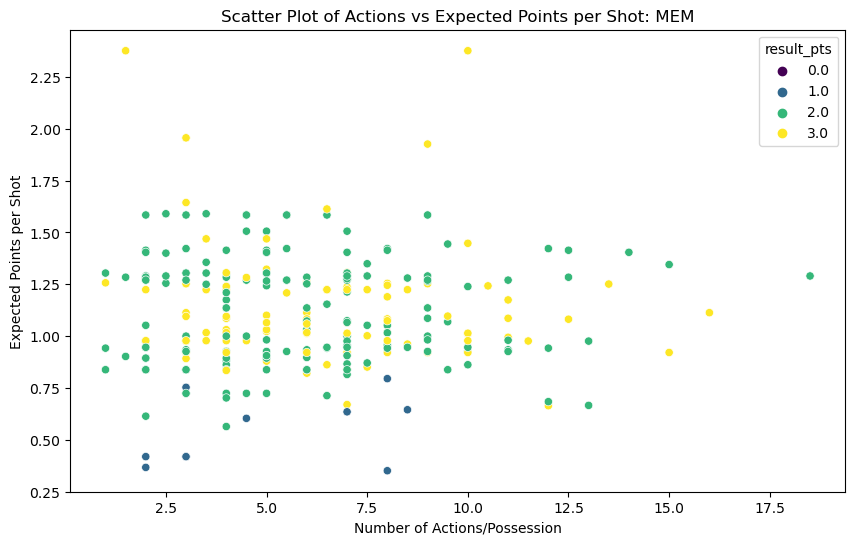

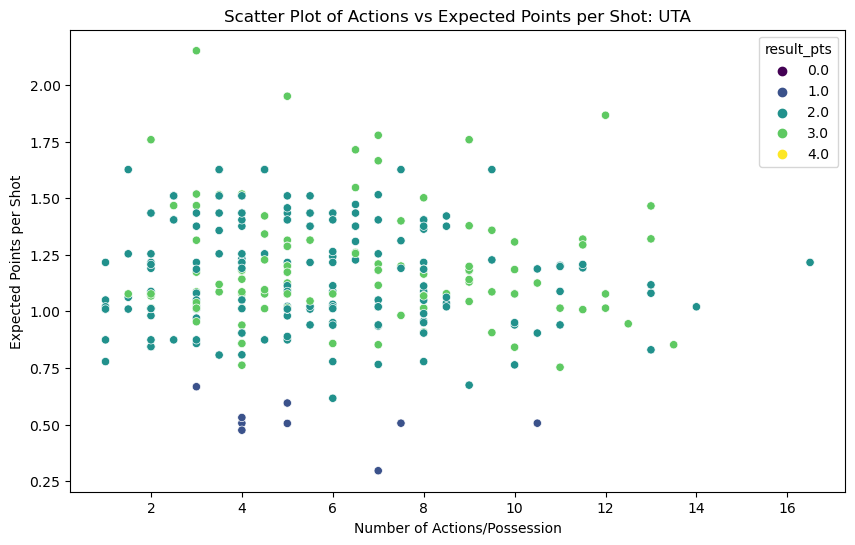

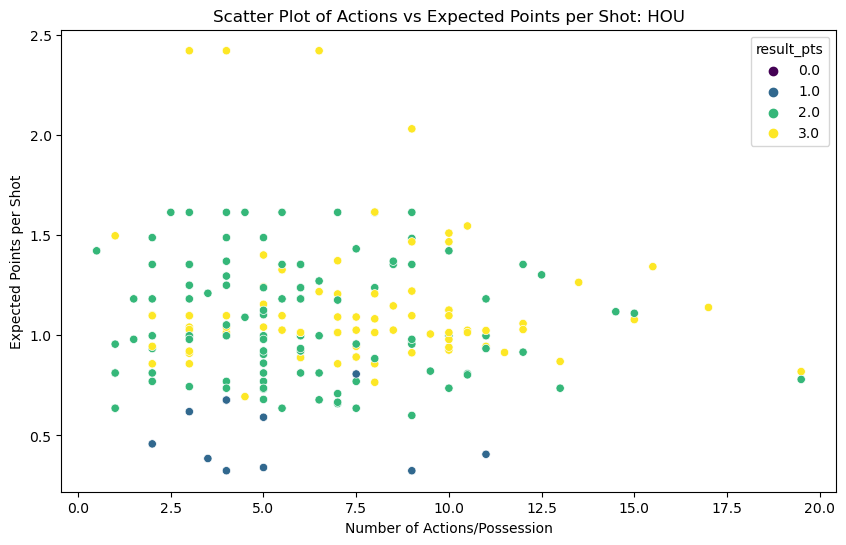

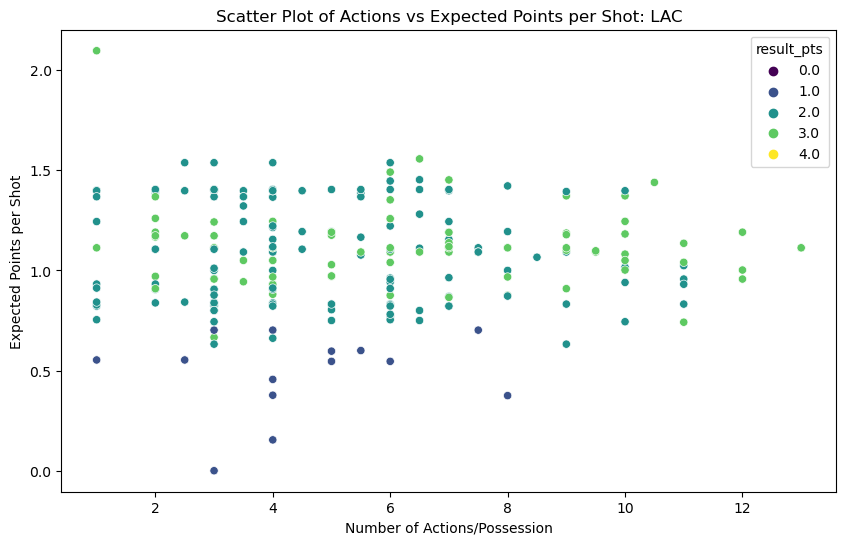

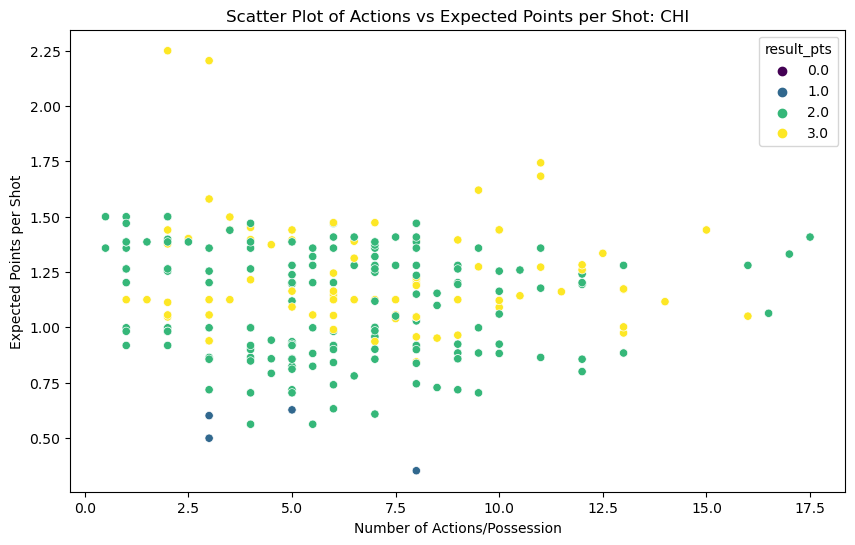

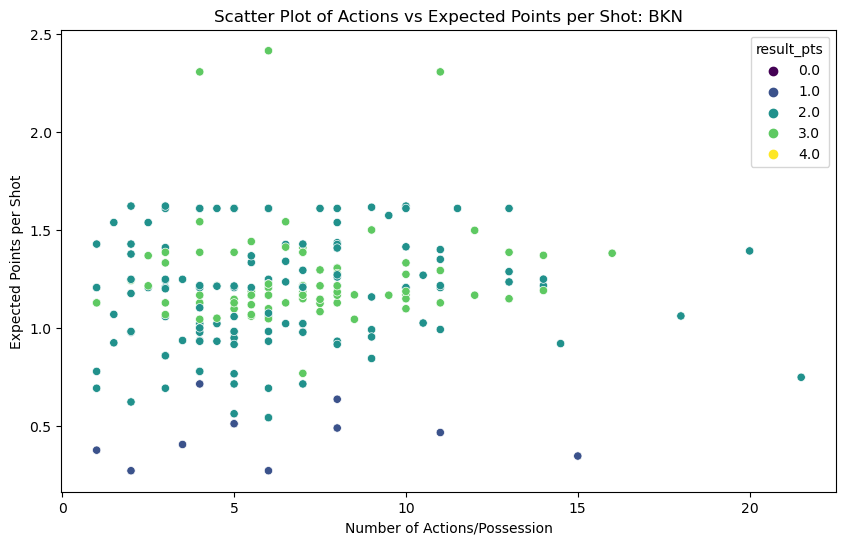

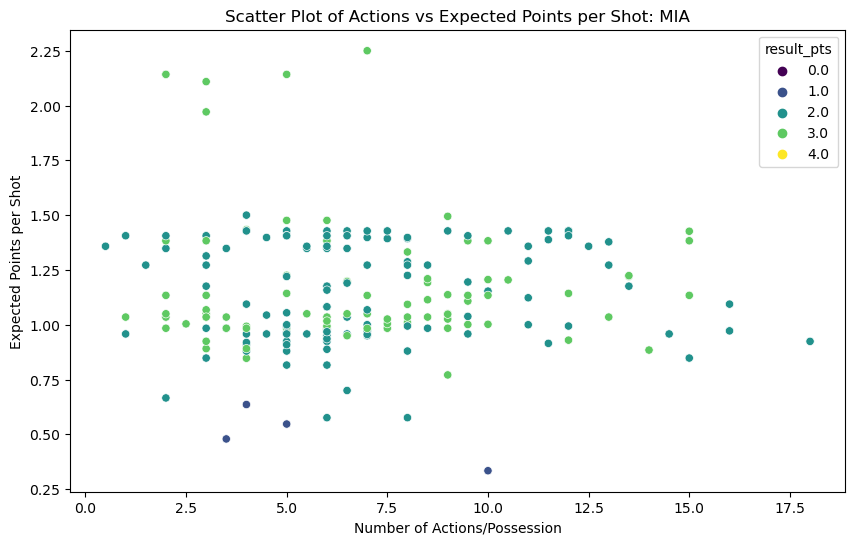

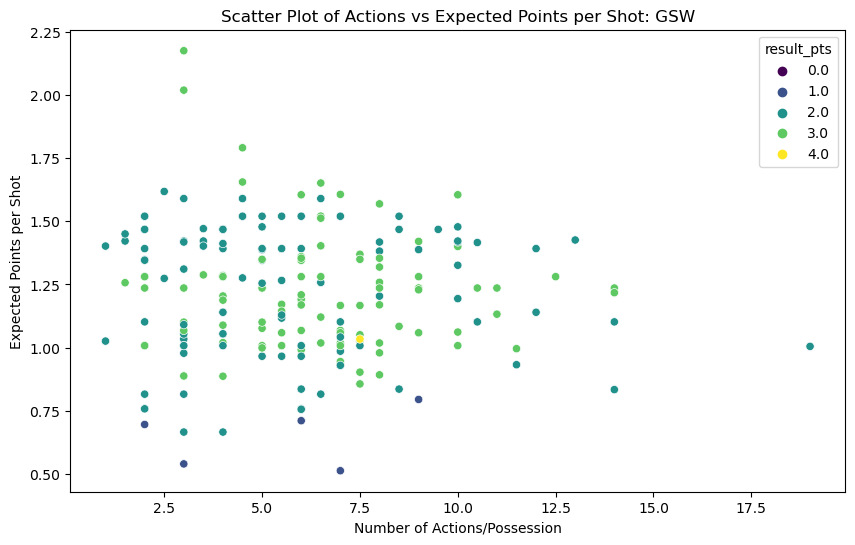

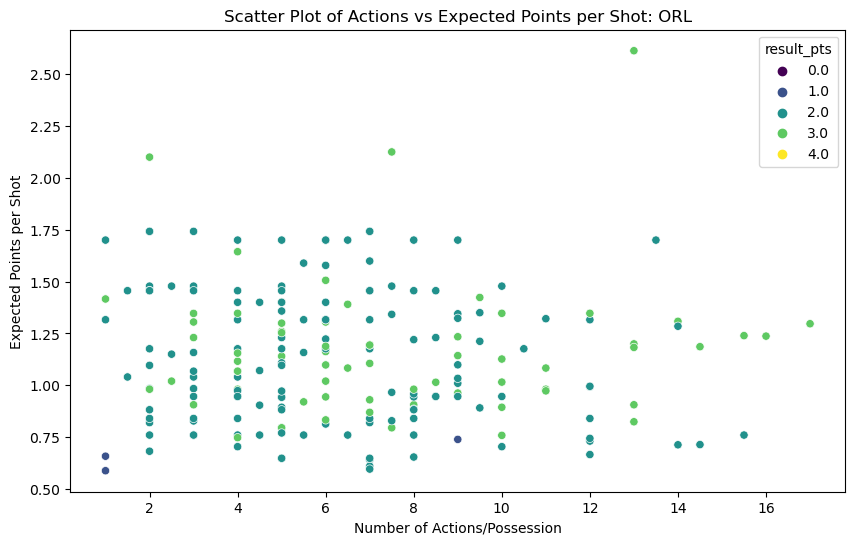

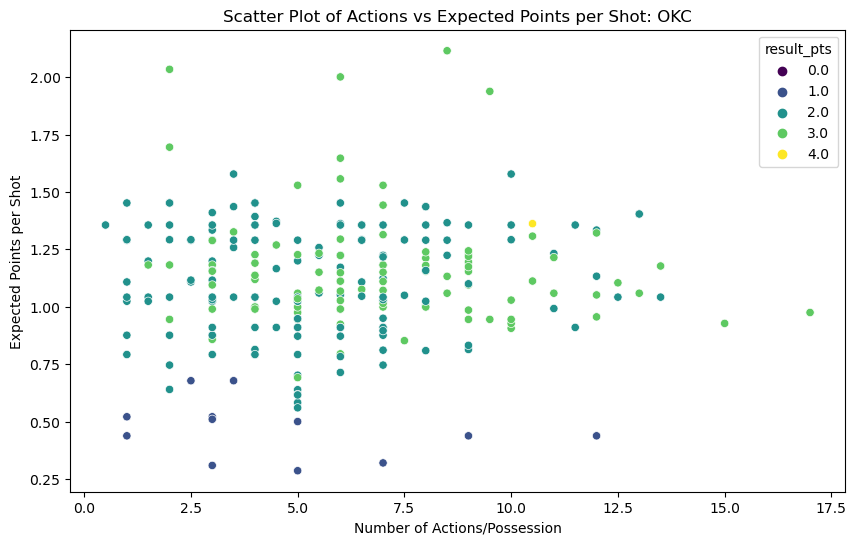

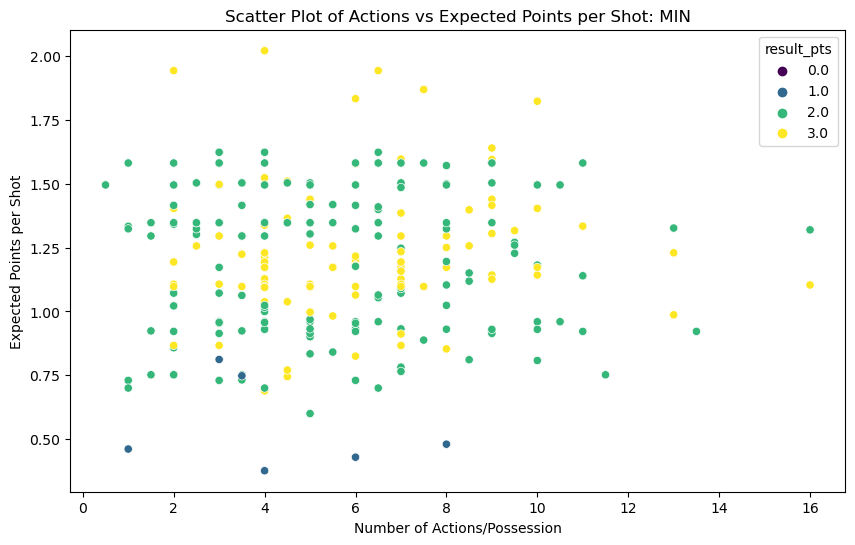

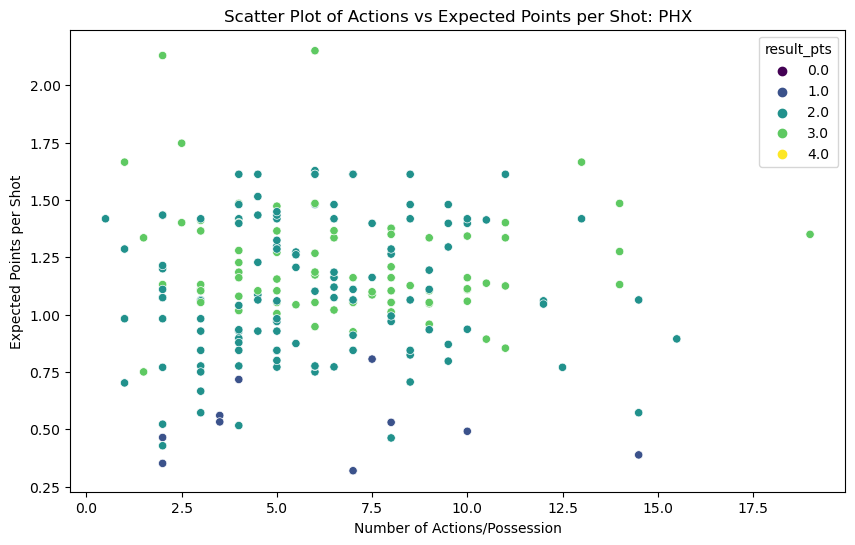

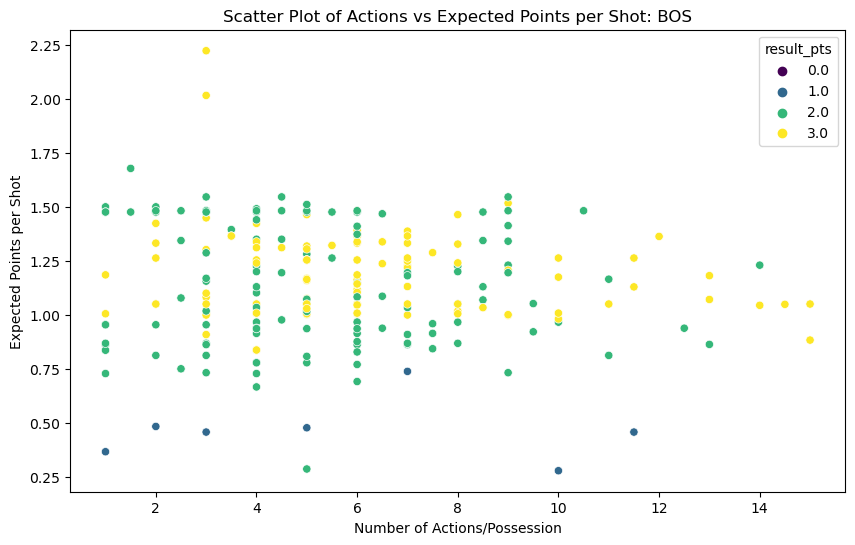

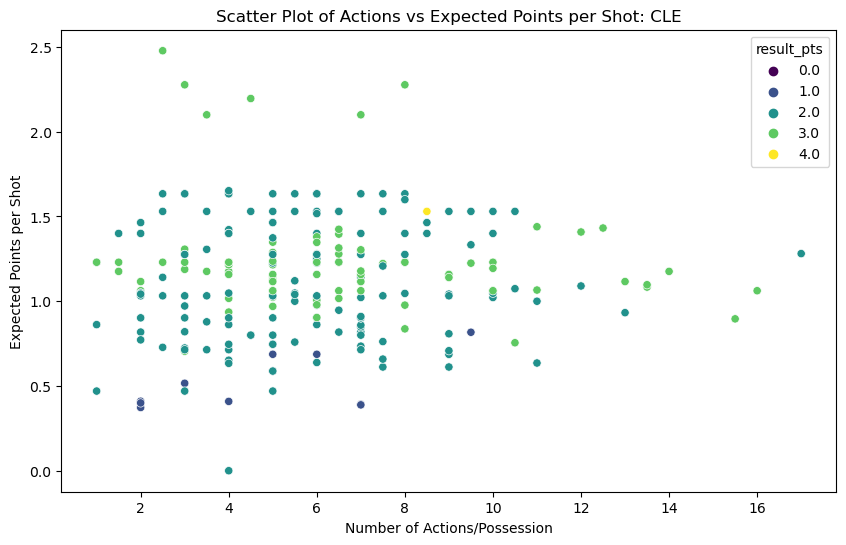

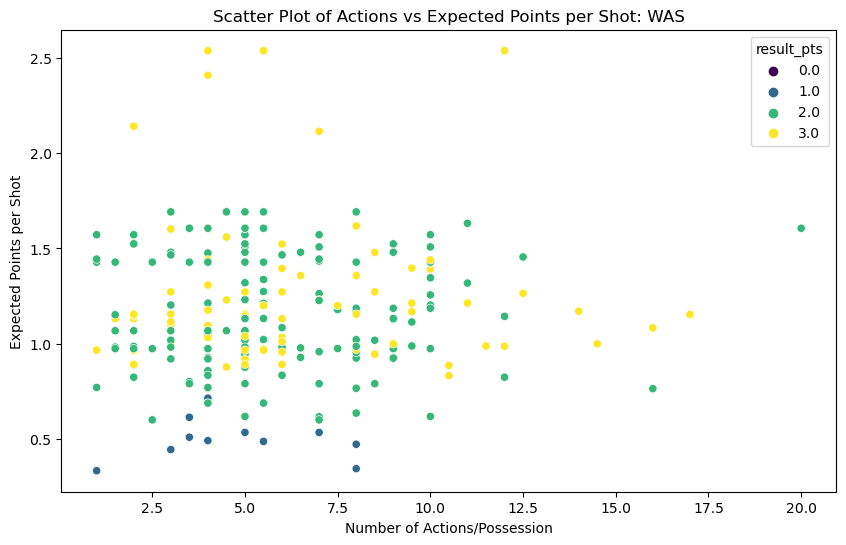

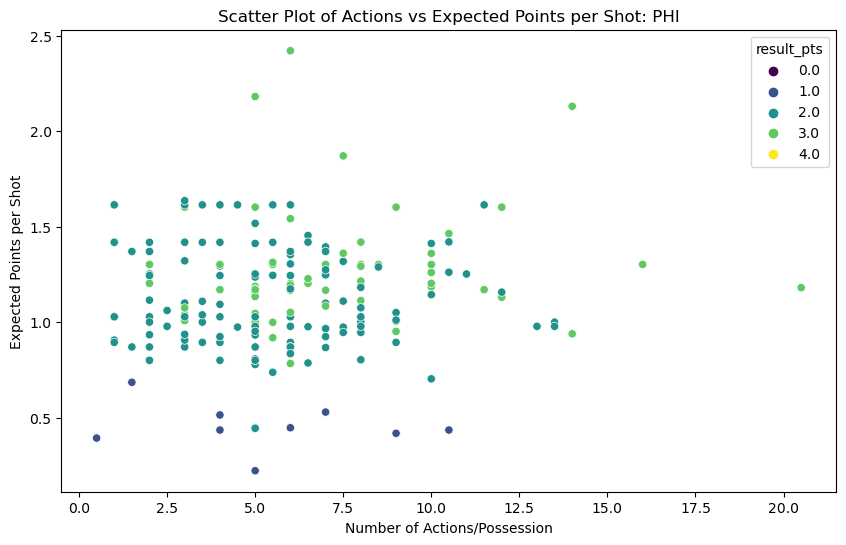

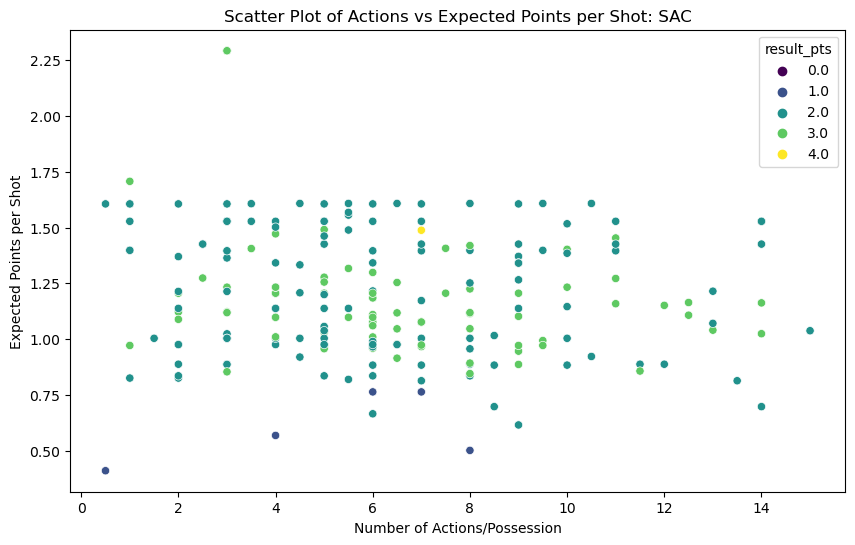

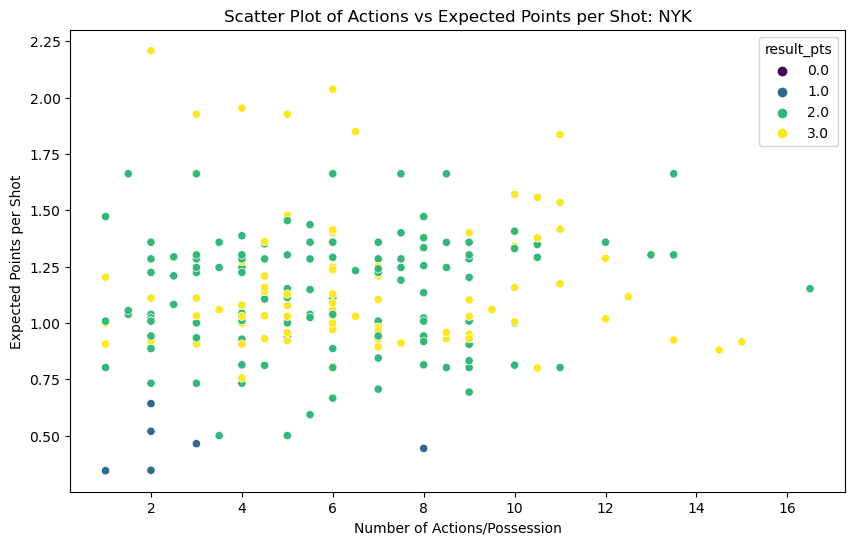

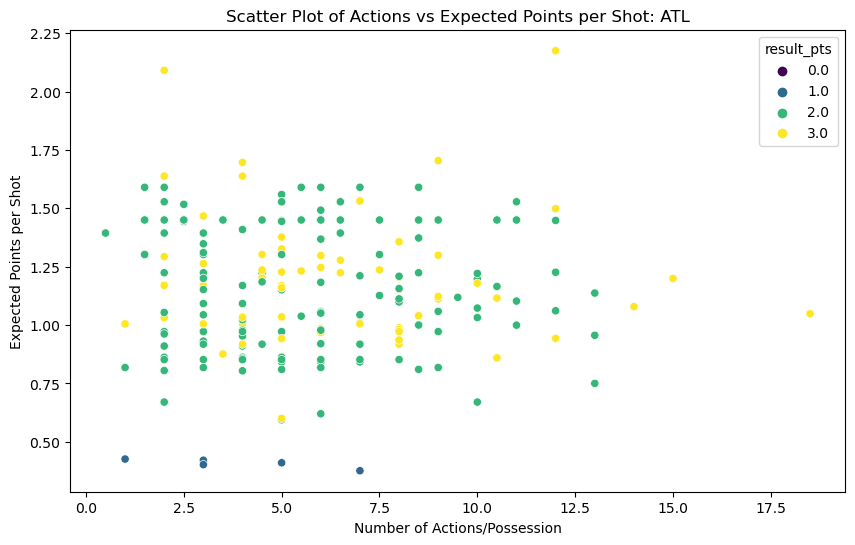

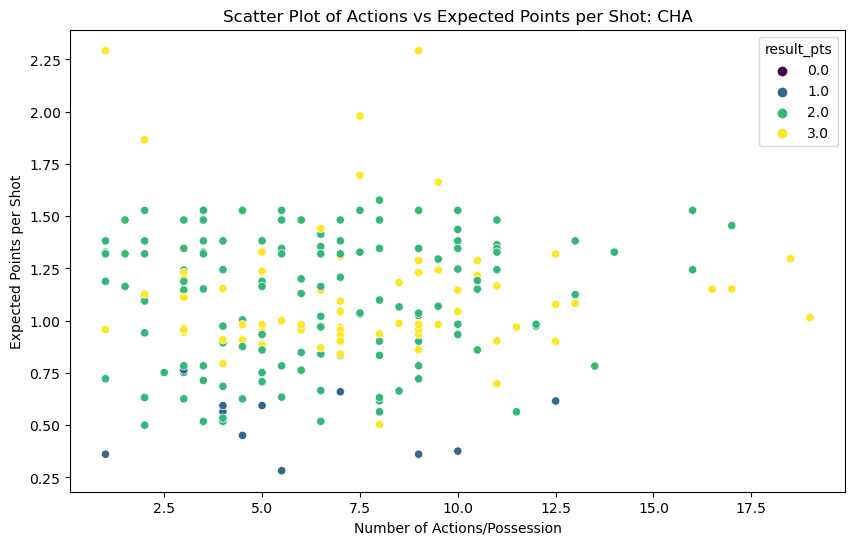

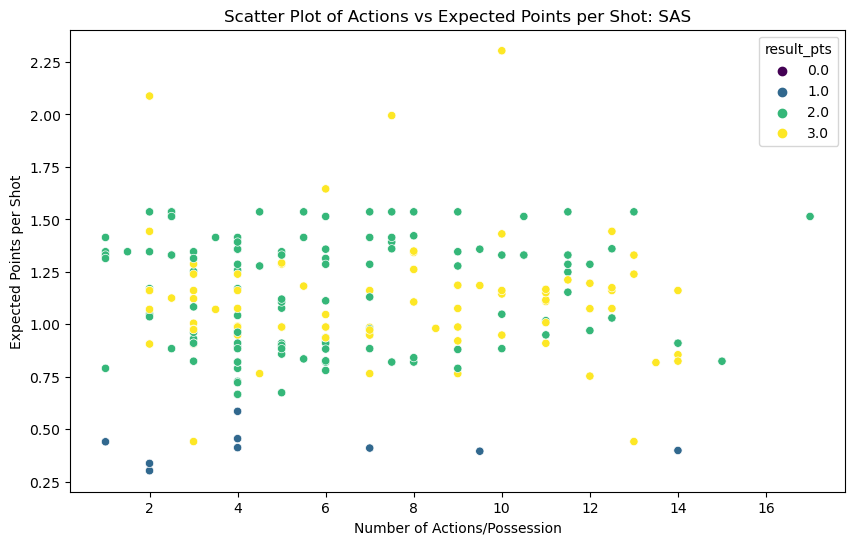

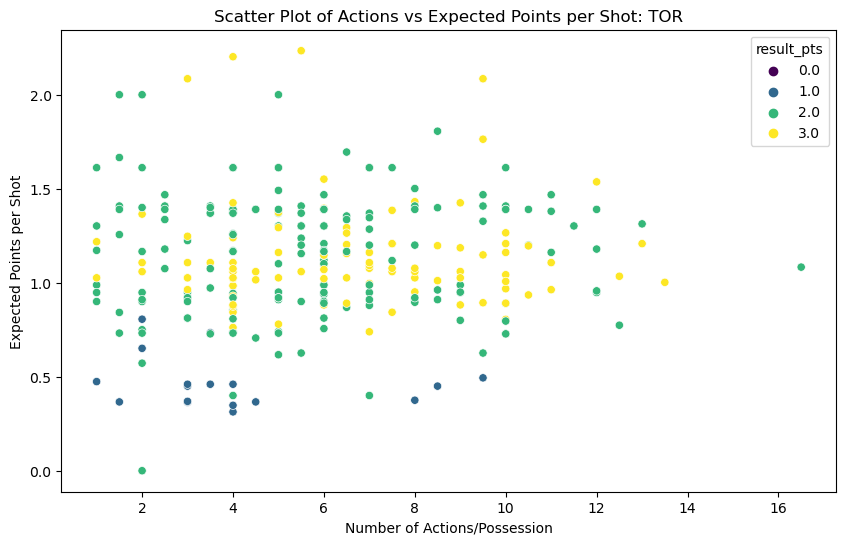

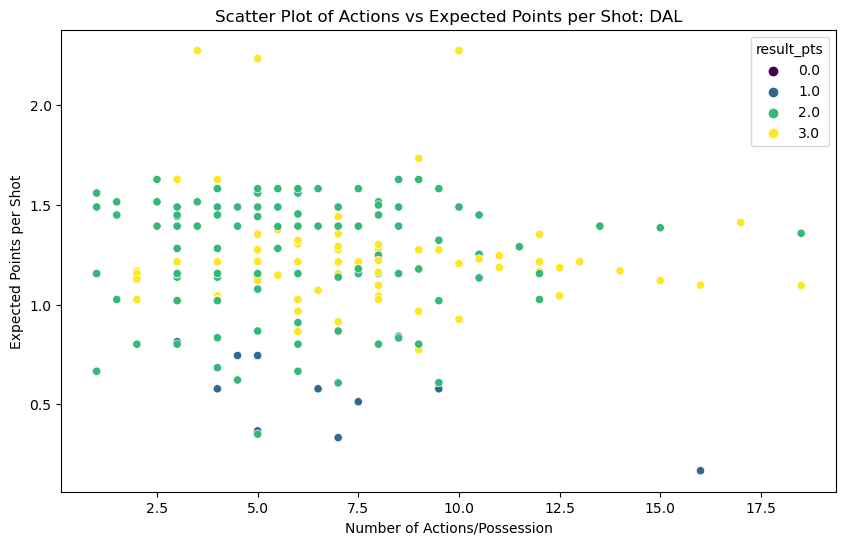

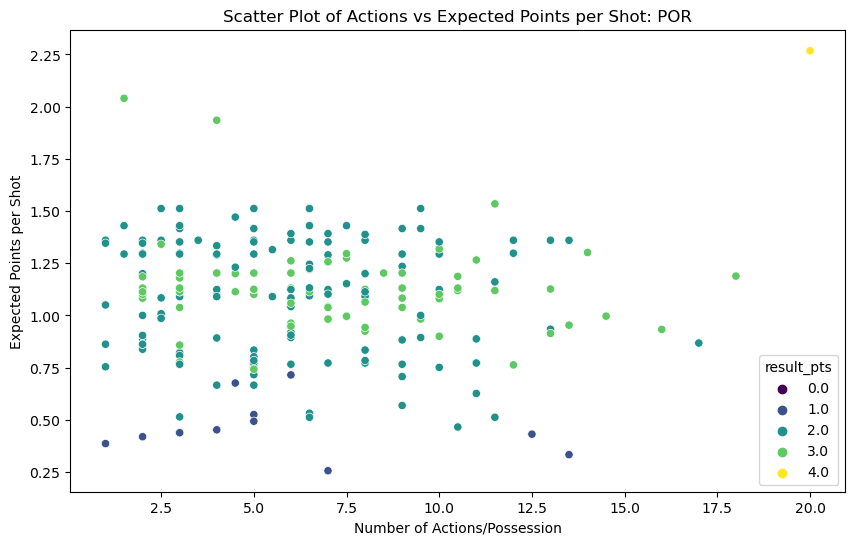

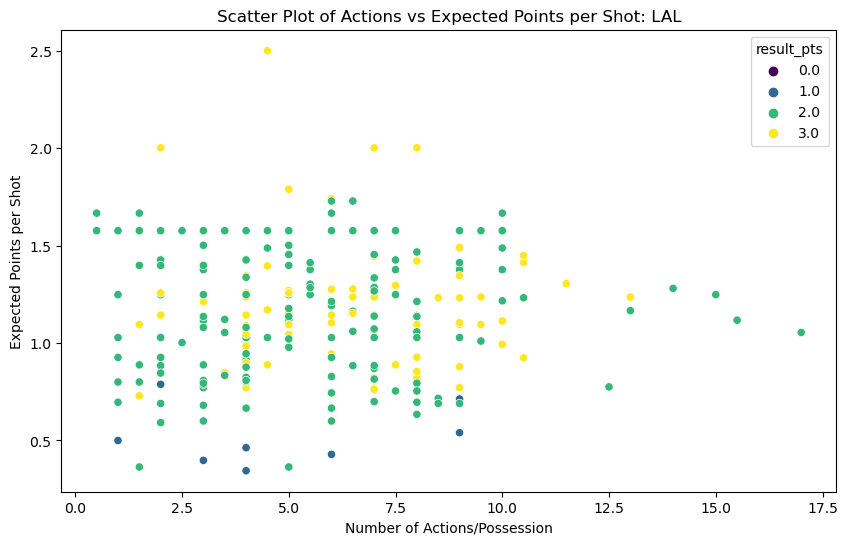

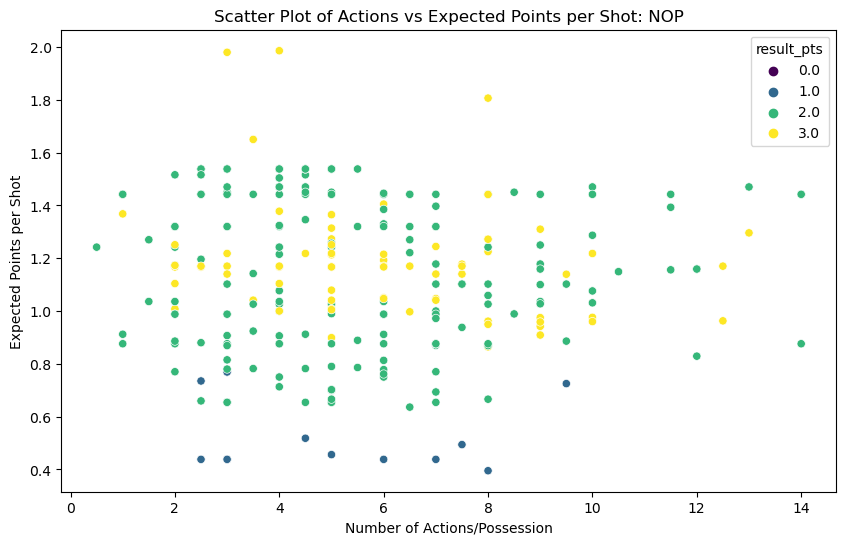

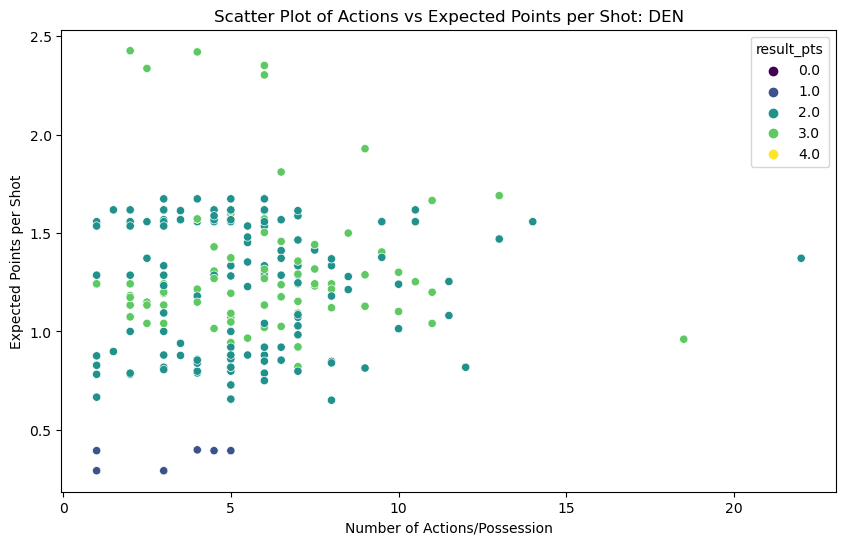

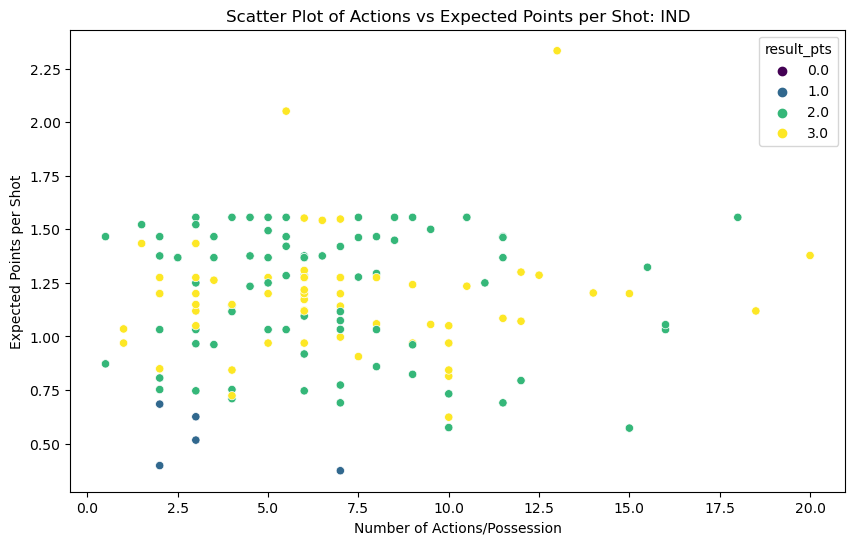

In [60]:
def fill_result_pts(group):
    if (group['result_pts'] >= 0).any():
        group['result_pts'] = group['result_pts'].max()
    return group

group_columns = ['off_team', 'nba_game_id', 'poss_id']

result_df = data.groupby(group_columns, group_keys=False).apply(fill_result_pts)
result_df = result_df.reset_index()
lowest_level = 'poss_id'

for off_team in result_df['off_team'].unique():
    off_team_data = result_df[result_df['off_team'] == off_team]
    scatter_data = off_team_data.groupby(['nba_game_id', lowest_level]).apply(lambda x: pd.Series({
        'row_count': x.shape[0] / 2,
        'Expected Points per Shot': x['Expected Points per Shot'].mean(),
        'result_pts': x['result_pts'].mean()
    })).reset_index()

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='row_count', y='Expected Points per Shot', hue='result_pts', data=scatter_data, palette='viridis')
    plt.title(f'Scatter Plot of Actions vs Expected Points per Shot: {off_team}')
    plt.xlabel('Number of Actions/Possession')
    plt.ylabel('Expected Points per Shot')
    plt.show()